In [1]:
import torch
from hybrid_model_ferm.utils import get_simulation_dir, get_models_dir, get_evaluation_dir
from hybrid_model_ferm.data.utils import load_batchset, dataloader
import os
from hybrid_model_ferm import model_evaluation as eval
import json
import wandb
import numpy as np
import pandas as pd
from hybrid_model_ferm.fault_detect_models.ml_models import nn_fdm
from hybrid_model_ferm.visualizations import visualize
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import json
import pickle
import joblib
import matplotlib.patches as mpatches

seed = 42 # set seeding for reproducibility

## Validation of all models

### Loading datasets

In [29]:
sim_dir = get_simulation_dir() # get directory of simulation data
model_dir = get_models_dir() # get directory of models
eval_dir = get_evaluation_dir() # get directory to save evaluation results
target_cols = ['defect_steambarrier', 'steam_in_feed', 'blocked_spargers', 'airflow_OOC', 'OUR_OOC', 'no_fault'] # target columns without feature engineering
target_cols_FE = ['steam_fault', 'blocked_spargers', 'airflow_OOC', 'OUR_OOC', 'no_fault'] # target columns with feature engineering
############################################
save_folder = "validation__extrapol_thesis" # folder name to save results
############################################
save_dir = os.path.join(eval_dir, save_folder) # directory to save results
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_set_name = "Train_1000" # training set name
train_set_name_MPCA = "Train_1000_MPCA"
train_set_name_SVM = "Train_250_SVM"

############################################
val_set_name = "Val_1000_extrapo" # validation set name
############################################

# Load training set for MPCA, PLS-DA and ANN
train_set = load_batchset(os.path.join(sim_dir, train_set_name))
train_dl = dataloader(batchset = train_set[:], batch_size=1, seed=seed)
train_dl.standardize_data(exclude_cols=target_cols)

# Standardize validation set based on training set
val_set = load_batchset(os.path.join(sim_dir, val_set_name))
val_dl = dataloader(batchset = val_set[:].copy(), batch_size=1, seed=seed)
val_dl.import_standardization(train_dl)
val_dl.standardize_data(exclude_cols=target_cols)

del train_set, train_dl

# Separate dataloader for feature engineering
train_set_FE = load_batchset(os.path.join(sim_dir, train_set_name))
train_dl_FE = dataloader(batchset = train_set_FE[:], batch_size=1, seed=seed)
train_dl_FE.combine_fault_events(['defect_steambarrier', 'steam_in_feed'], 'steam_fault')
train_dl_FE.apply_airflow_preprocess(target_cols_FE)
train_dl_FE.standardize_data(exclude_cols=target_cols_FE)

val_set_FE = load_batchset(os.path.join(sim_dir, val_set_name))
val_dl_FE = dataloader(batchset = val_set_FE[:], batch_size=1, seed=seed)
val_dl_FE.combine_fault_events(['defect_steambarrier', 'steam_in_feed'], 'steam_fault')
val_dl_FE.apply_airflow_preprocess(target_cols_FE)
val_dl_FE.import_standardization(train_dl_FE)
val_dl_FE.standardize_data(exclude_cols=target_cols_FE)

del train_set_FE, train_dl_FE

# Load training set for MPCA
train_set_MPCA = load_batchset(os.path.join(sim_dir, train_set_name_MPCA))
train_dl_MPCA = dataloader(batchset = train_set_MPCA[:], batch_size=1, seed=seed)
train_dl_MPCA.standardize_data(exclude_cols=target_cols)

# Standardize validation set based on training set
val_set_MPCA = load_batchset(os.path.join(sim_dir, val_set_name))
val_dl_MPCA = dataloader(batchset = val_set_MPCA[:], batch_size=1, seed=seed)
val_dl_MPCA.import_standardization(train_dl_MPCA)
val_dl_MPCA.standardize_data(exclude_cols=target_cols)

del train_set_MPCA, train_dl_MPCA

# Load training set for SVM
train_set_SVM = load_batchset(os.path.join(sim_dir, train_set_name_SVM))
train_dl_SVM = dataloader(batchset = train_set_SVM[:], batch_size=1, seed=seed)
train_dl_SVM.standardize_data(exclude_cols=target_cols)

# Standardize validation set based on training set
val_set_SVM = load_batchset(os.path.join(sim_dir, val_set_name))
val_dl_SVM = dataloader(batchset = val_set_SVM[:], batch_size=1, seed=seed)
val_dl_SVM.import_standardization(train_dl_SVM)
val_dl_SVM.standardize_data(exclude_cols=target_cols)

del train_set_SVM, train_dl_SVM

# Retrieve validation data from dataloaders
val_X, val_Y_fused = val_dl.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=True)
_, val_Y_unfused = val_dl.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=False)

val_X_FE, val_Y_FE = val_dl_FE.get_data(split_batches=False, target_cols=target_cols_FE, separate_target_matrix=True, fuse_target_cols=False)

val_X_MPCA, _ = val_dl_MPCA.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=True)

val_X_SVM, _ = val_dl_SVM.get_data(split_batches=False, target_cols=target_cols, separate_target_matrix=True, fuse_target_cols=True)

del val_dl, val_dl_FE, val_dl_MPCA, val_dl_SVM

### Loading models

In [3]:
### Load MPCA model ###
from hybrid_model_ferm.fault_detect_models.ml_models import pca_fdm
model_name = "MPCA_Thesis_lowalpha" # set model name to load
load_save_path = os.path.join(model_dir, model_name, "model.pkl")
with open(load_save_path, 'rb') as file:
    pca_model = pickle.load(file)

In [4]:
### Load PLS-DA model ###
model_name = "PLSDA_Thesis"
load_save_path = os.path.join(model_dir, model_name, "model.pkl")
with open(load_save_path, 'rb') as file:
    pls_model = pickle.load(file)

In [5]:
### Load SVM model ###
model_name = "SVM_Thesis"
load_save_path = os.path.join(model_dir, model_name, "model.pkl")
with open(load_save_path, 'rb') as file:
    svm_model = pickle.load(file)
#svm_model.mw = 1

In [6]:
### Load ANN model for detection ###
model_name = "ANN_detect_thesis"
input_dim = 8
output_dim = 2
hidden_layer = [40]
mode = "one_class"
mw = 1

# Initialize model
nn_detect_model = nn_fdm(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layer, mode=mode, mw=mw, seed=seed)

# Load model
load_save_path = os.path.join(model_dir, model_name, "model.pth")
nn_detect_model.load_model(load_save_path)

In [7]:
### Load ANN model for diagnosis ###
model_name = "ANN_diagnosis_thesis"
input_dim = 8
output_dim = 6
hidden_layer = [60]
mode = "mult_class"
mw = 1

# Initialize model
nn_diagnosis_model = nn_fdm(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layer, mode=mode, mw=mw, seed=seed)

# Load model
load_save_path = os.path.join(model_dir, model_name, "model.pth")
nn_diagnosis_model.load_model(load_save_path)

In [8]:
### Load ANN model for diagnosis with FE ###
model_name = "ANN_diagnosis_FE_thesis"
input_dim = 8
output_dim = 5
hidden_layer = [60]
mode = "mult_class"
mw = 1

# Initialize model
nn_diagnosis_FE_model = nn_fdm(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layer, mode=mode, mw=mw, seed=seed)

# Load model
load_save_path = os.path.join(model_dir, model_name, "model.pth")
nn_diagnosis_FE_model.load_model(load_save_path)

### Predictions of models

In [9]:
### MPCA ###
predictions_pca = pca_model.predict(val_X_MPCA)
metrics_pca = eval.metrics_table_oneclass(val_Y_unfused, predictions_pca["fault"])

In [10]:
### PLS-DA ###
predictions_pls = pls_model.predict(val_X)
metrics_pls = eval.metrics_table_oneclass(val_Y_unfused, predictions_pls["fault"])

In [11]:
### SVM ###
predictions_svm = svm_model.predict(val_X_SVM)
metrics_svm = eval.metrics_table_oneclass(val_Y_unfused, predictions_svm["fault"])

In [12]:
### ANN detect ###
predictions_nn_detect = nn_detect_model.predict(val_X)
metrics_nn_detect = eval.metrics_table_oneclass(val_Y_unfused, predictions_nn_detect["fault"])

In [13]:
### ANN diagnosis ###
predictions_nn_diagnosis = nn_diagnosis_model.predict(val_X, output_columns=val_Y_unfused.columns)
metrics_nn_diagnosis = eval.metrics_table_multclass(val_Y_unfused, predictions_nn_diagnosis, show_confusion_matrix=False)

In [14]:
### ANN diagnosis with FE ###
predictions_nn_diagnosis_FE = nn_diagnosis_FE_model.predict(val_X_FE, output_columns=val_Y_FE.columns)
metrics_nn_diagnosis_FE = eval.metrics_table_multclass(val_Y_FE, predictions_nn_diagnosis_FE, show_confusion_matrix=False)

In [15]:
metrics_pca

,Fault detection rate,False alarm rate,Accuracy
defect_steambarrier,0.085043,NaN,NaN
steam_in_feed,0.101953,NaN,NaN
blocked_spargers,0.984466,NaN,NaN
airflow_OOC,1.000000,NaN,NaN
OUR_OOC,0.434796,NaN,NaN
overall,0.562146,0.00842,0.776863


In [16]:
metrics_pls

,Fault detection rate,False alarm rate,Accuracy
defect_steambarrier,0.805081,NaN,NaN
steam_in_feed,0.789163,NaN,NaN
blocked_spargers,0.936744,NaN,NaN
airflow_OOC,0.494404,NaN,NaN
OUR_OOC,0.284639,NaN,NaN
overall,0.628056,0.073536,0.77726


In [17]:
metrics_svm

,Fault detection rate,False alarm rate,Accuracy
defect_steambarrier,0.899646,NaN,NaN
steam_in_feed,0.859109,NaN,NaN
blocked_spargers,0.987711,NaN,NaN
airflow_OOC,0.993961,NaN,NaN
OUR_OOC,0.969991,NaN,NaN
overall,0.949191,0.020521,0.964335


In [18]:
metrics_nn_detect

,Fault detection rate,False alarm rate,Accuracy
defect_steambarrier,0.787115,NaN,NaN
steam_in_feed,0.763817,NaN,NaN
blocked_spargers,0.984164,NaN,NaN
airflow_OOC,0.994152,NaN,NaN
OUR_OOC,0.982974,NaN,NaN
overall,0.917370,0.001908,0.957731


In [19]:
metrics_nn_diagnosis

,Fault detection rate,False alarm rate,Accuracy
defect_steambarrier,0.127362,0.000001,0.563680
steam_in_feed,0.658976,0.001898,0.828539
blocked_spargers,0.822723,0.000000,0.911361
airflow_OOC,0.825835,0.000000,0.912917
OUR_OOC,0.982239,0.000000,0.991120
overall,0.920641,0.001900,0.959371


In [20]:
metrics_nn_diagnosis_FE

,Fault detection rate,False alarm rate,Accuracy
steam_fault,0.795103,0.002045,0.896529
blocked_spargers,0.863752,0.000000,0.931876
airflow_OOC,0.919443,0.000000,0.959722
OUR_OOC,0.979891,0.000000,0.989946
overall,0.924287,0.002045,0.961121


In [21]:
FDR_detect_models = pd.concat([metrics_pca["Fault detection rate"], metrics_pls["Fault detection rate"], metrics_svm["Fault detection rate"], metrics_nn_detect["Fault detection rate"]], axis = 1)
FDR_detect_models.reset_index(inplace = True)
FDR_detect_models.columns = ['Fault type', 'MPCA', 'PLS-DA', 'SVM', 'ANN Detect']
FDR_detect_models["Fault type"] = FDR_detect_models["Fault type"].map(visualize.get_label_dict())

# Save to csv
save_path = os.path.join(save_dir, "FDR_detect_models.csv")
pd.DataFrame(FDR_detect_models).to_csv(save_path, index = False)

In [22]:
FDR_diagnosis_models = pd.concat([metrics_nn_diagnosis["Fault detection rate"], metrics_nn_diagnosis_FE["Fault detection rate"]], axis=1)
FDR_diagnosis_models.columns = ['ANN', 'ANN with FE']
sum_steamfaults = FDR_diagnosis_models.loc["defect_steambarrier","ANN"] + FDR_diagnosis_models.loc["steam_in_feed","ANN"]
FDR_diagnosis_models.loc["steam_fault","ANN"] = sum_steamfaults
FDR_diagnosis_models.drop("defect_steambarrier", inplace=True)
FDR_diagnosis_models.drop("steam_in_feed", inplace=True)
FDR_diagnosis_models.reset_index(inplace=True)
FDR_diagnosis_models.rename(columns={"index":"Fault type"}, inplace=True)

# move steam faults column to the front
FDR_diagnosis_models = pd.concat([FDR_diagnosis_models[FDR_diagnosis_models['Fault type'] == "steam_fault"], 
                                  FDR_diagnosis_models[FDR_diagnosis_models['Fault type'] != "steam_fault"]])
FDR_diagnosis_models["Fault type"] = FDR_diagnosis_models["Fault type"].map(visualize.get_label_dict())

# Save to csv
save_path = os.path.join(save_dir, "FDR_diagnosis_models.csv")
pd.DataFrame(FDR_diagnosis_models).to_csv(save_path, index = False)

In [23]:
# Create dataframe with overall metrics from all models
metrics_dataframes = [metrics_pca, metrics_pls, metrics_svm, metrics_nn_detect, metrics_nn_diagnosis, metrics_nn_diagnosis_FE]
overall_metrics = pd.concat([df.loc["overall"] for df in metrics_dataframes], axis=1)
#overall_metrics.reset_index(inplace=True)
overall_metrics = overall_metrics.T
overall_metrics.reset_index(inplace=True)
overall_metrics.drop("index", axis=1, inplace=True)
overall_metrics["Models"] = ["MPCA", "PLS-DA", "SVM", "ANN (detect)", "ANN (diagnosis)", "ANN (diagnosis & FE)"]

# Save to csv
save_path = os.path.join(save_dir, "overall_metrics.csv")
pd.DataFrame(overall_metrics).to_csv(save_path, index = False)

### Comparison of models for detection

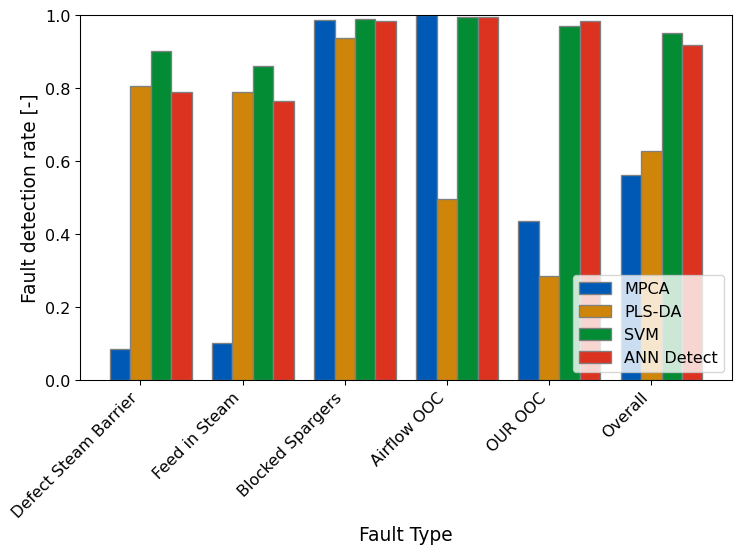

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

# Define the bar width
bar_width = 0.2

# Set positions of the bars on the x-axis
r1 = np.arange(len(FDR_detect_models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
colors = visualize.get_thesis_colors()
plt.bar(r1, FDR_detect_models['MPCA'], color=colors["blue"], width=bar_width, edgecolor='grey', label='MPCA')
plt.bar(r2, FDR_detect_models['PLS-DA'], color=colors["lemon"], width=bar_width, edgecolor='grey', label='PLS-DA')
plt.bar(r3, FDR_detect_models['SVM'], color=colors["green"], width=bar_width, edgecolor='grey', label='SVM')
plt.bar(r4, FDR_detect_models['ANN Detect'], color=colors["red"], width=bar_width, edgecolor='grey', label='ANN Detect')

# Add labels
plt.xlabel('Fault Type')
plt.ylabel('Fault detection rate [-]')
plt.ylim(0, 1)

plt.xticks([r + bar_width for r in range(len(FDR_detect_models))], FDR_detect_models['Fault type'], rotation=45, ha='right')

# Create legend & Show graphic

#plt.rcParams['figure.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "FDR_detect_models.png"), dpi=300)
plt.show()

### Comparison of models for diagnosis

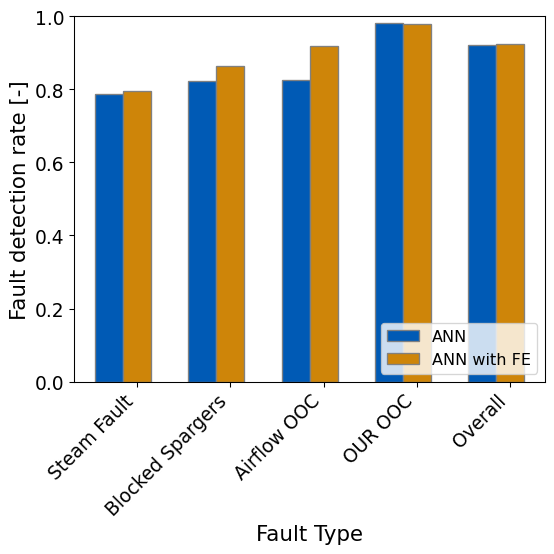

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define the bar width
bar_width = 0.3

# Set positions of the bars on the x-axis
r1 = np.arange(len(FDR_diagnosis_models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
colors = visualize.get_thesis_colors()
plt.bar(r1, FDR_diagnosis_models['ANN'], color=colors["blue"], width=bar_width, edgecolor='grey', label='ANN')
plt.bar(r2, FDR_diagnosis_models['ANN with FE'], color=colors["lemon"], width=bar_width, edgecolor='grey', label='ANN with FE')

# Add labels
plt.xlabel('Fault Type')
plt.ylabel('Fault detection rate [-]')
plt.ylim(0, 1)

plt.xticks([r + bar_width for r in range(len(FDR_diagnosis_models))], FDR_diagnosis_models['Fault type'], rotation=45, ha='right')

# Create legend & Show graphic

#plt.rcParams['figure.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "FDR_diagnosis_models.png"), dpi=300)
plt.show()

### Overall comparison

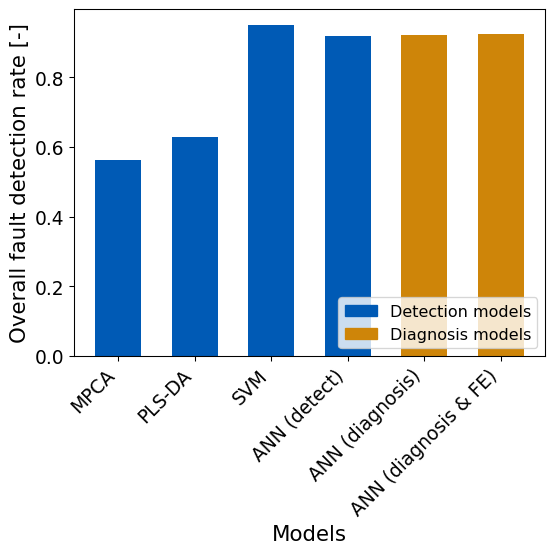

In [30]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Define the bar width
bar_width = 0.6

# Set positions of the bars on the x-axis
r1 = np.arange(len(overall_metrics))

# Make the plot
colors = visualize.get_thesis_colors()
colors_plot = [colors["blue"], colors["blue"], colors["blue"], colors["blue"], colors["lemon"], colors["lemon"]]
plt.bar(r1, overall_metrics['Fault detection rate'], color=colors_plot, width=bar_width, label='Models')

# Add labels
plt.xlabel('Models')
plt.ylabel('Overall fault detection rate [-]')
plt.ylim(0, )

plt.xticks(r1, overall_metrics['Models'], rotation=45, ha='right')

# Create custom legend handles
detect_model_patch = mpatches.Patch(color=colors["blue"], label='Detection models')
diagnosis_model_patch = mpatches.Patch(color=colors["lemon"], label='Diagnosis models')

# Create legend & Show graphic
#plt.rcParams['figure.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.legend(handles=[detect_model_patch, diagnosis_model_patch], loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "overall_FDR.png"), dpi=300)
plt.show()

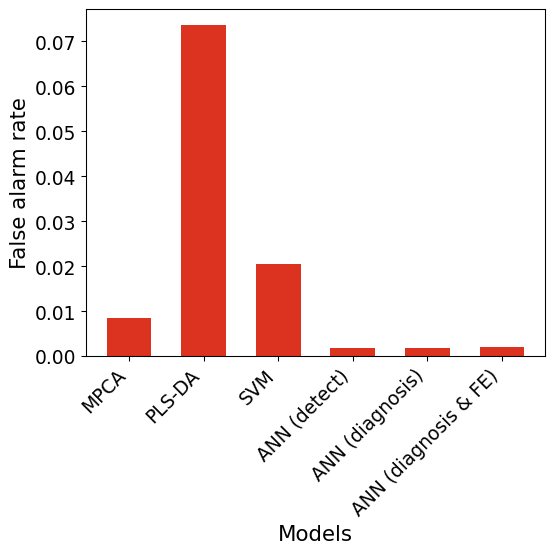

In [27]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Define the bar width
bar_width = 0.6

# Set positions of the bars on the x-axis
r1 = np.arange(len(overall_metrics))

# Make the plot
plt.bar(r1, overall_metrics['False alarm rate'], color=colors["red"], width=bar_width, label='Models')

# Add labels
plt.xlabel('Models')
plt.ylabel('False alarm rate')
#plt.ylim(0, 0.06)

plt.xticks(r1, overall_metrics['Models'], rotation=45, ha='right')

# Create legend & Show graphic
#plt.rcParams['figure.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "overall_FAR.png"), dpi=300)
plt.show()